## Setup

In [610]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
    make_scorer,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator

!pip install torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Local modules

In [611]:
# Adding to path the path
sys.path.append("../pipelines")

from utils.dataset import DataIntoLocalFile, CreateDF

## Loading the Data

In [612]:
# Dentro de CreateDF elimina duplicados, podría separarse en otra función.
def download_save_flare_data():
    data_local = DataIntoLocalFile()
    saved_path = data_local.download_and_extract()
    df_class = CreateDF(saved_path)
    data = df_class.create_dataframe()
    return data

def load_data(filepath):
    data = pd.read_csv(filepath, index_col=False)
    return data

def explore_data(data):
    print("\nPrimeras 10 filas de 'data' Dataframe")
    print(data.head().T)
    print("\nEstadísticas descriptivas:")
    print(data.describe())

    print("\nInformación sobre el 'data' Dataframe")
    print(data.info())

    print("\nCantidad de Valores Faltantes")
    print(data.isnull().sum())

## Adding visualizations 

In [613]:
def histograma_variables_numéricas(data):
    print("\nHistograma para Variables Numéricas")
    # Crear grid de subplots
    fig, axes = plt.subplots(3, 3, figsize=(15,12))
    axes = axes.flatten()  # Convertir a una lista para iterar
    
    # Iterar sobre columnas numéricas y ejes
    for i, col in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
        sns.histplot(data[col], kde=True, bins=30, color='blue', ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

In [614]:
def gráficos_variables_categóricas(data):
    print("\nGráficos de Barras para Variables Categóricas")
    for col in data.select_dtypes(include=['object']).columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(y=data[col],hue=data[col],palette='viridis', order=data[col].value_counts().index)
        plt.title(f'Conteo de {col}')
        plt.xlabel('Frecuencia')
        plt.ylabel(col)
        plt.show()

In [615]:
# Visualizar la Distribución de Flare vs No Flare
def plot_distribution(data_df):
    data_df_temp = data_df.copy()
    if 'Flare' not in data_df.columns:
        data_df_temp['Flare'] = (
            (data_df_temp['common flares'] > 0) | 
            (data_df_temp['moderate flares'] > 0) | 
            (data_df_temp['severe flares'] > 0)
        )
    
    # Visualize the Distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Flare', data=data_df_temp)
    plt.title('Distribución de Clases: Flare vs No Flare')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.xticks(ticks=[0, 1], labels=["No Flare", "Flare"])
    plt.show()


In [616]:
def plot_histograms(data_df,targets, bins=15, figsize=(15, 10)):
    target_data = data_df[targets]
    target_data.hist(bins=bins, figsize=figsize)
    plt.suptitle("Distribution of Solar Flare Targets")
    plt.show()

In [617]:
def correlation_matrix(data_df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data_df.corr(), annot=True, fmt=".2f")
    plt.show()

In [618]:
def plot_pca_tsne(data_df, targets):
    features = data_df.drop(columns=targets)
    
    # Reducción de Dimensionalidad(2D): PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    
    # Reducción de Dimensionalidad(2D): t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # Generar gráficos para cada columna objetivo
    for target_col in targets:
        target = data_df[target_col]
        
        # Gráficos para PCA
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=target, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label=target_col)
        plt.title(f"Solar Flare Analysis - PCA ({target_col})")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        
        # Gráficos para t-SNE
        plt.subplot(1, 2, 2)
        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=target, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label=target_col)
        plt.title(f"Solar Flare Analysis - t-SNE ({target_col})")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        
        plt.tight_layout()
        plt.show()

## Preprocessing and Feature Engineering

In [619]:
# target_columns = ['common flares', 'moderate flares', 'severe flares']
def preprocess_data(data_df, columns_to_encode=None):
    if columns_to_encode is None:
        columns_to_encode = [
            "modified Zurich class",
            "largest spot size",
            "spot distribution",
        ]
    pipeline = Pipeline(
        [
            (
                "encode",
                make_column_transformer(
                    (OrdinalEncoder(), columns_to_encode), remainder="passthrough"
                ),
            ),
            # ('scale', MinMaxScaler()),  Podemos ir agregando más transformaciones de ser necesario.
        ]
    )
    encoded_scaled = pipeline.fit_transform(data_df)
    data_df_processed = pd.DataFrame(
        encoded_scaled, index=data_df.index, columns=data_df.columns
    )
    return data_df_processed

## Splitting the Dataset

In [620]:
# Pytorch dataset
class FlareDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[0][idx], self.y[1][idx], self.y[2][idx]


def split_data(data_df, test_size=0.2, random_state=42):
    target_output = lambda data: [
        np.array(data.pop("common flares")),
        np.array(data.pop("moderate flares")),
        np.array(data.pop("severe flares")),
    ]

    X_train, X_test = train_test_split(
        data_df, test_size=test_size, random_state=random_state
    )

    y_train = target_output(X_train)
    y_test = target_output(X_test)

    # PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = [
        torch.tensor(target, dtype=torch.float32).unsqueeze(1) for target in y_train
    ]
    y_test = [
        torch.tensor(target, dtype=torch.float32).unsqueeze(1) for target in y_test
    ]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", [target.shape for target in y_train])
    print("y_test shape:", [target.shape for target in y_test])

    return X_train, X_test, y_train, y_test


def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):

    train_dataset = FlareDataset(X_train, y_train)
    test_dataset = FlareDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## Training Linear Neural Network


In [621]:
# 2 capas Lineales
# Puede expandirse de manera directa capa por capa.
class SimpleMonnFlare3(nn.Module):
    def __init__(self, input_len=10):
        super(SimpleMonnFlare3, self).__init__()
        self.first_dense = nn.Linear(input_len, 64)
        self.second_dense = nn.Linear(64, 32)
        self.y1_output = nn.Linear(32, 1)
        self.y2_output = nn.Linear(32, 1)
        self.y3_output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.first_dense(x))
        x = torch.relu(self.second_dense(x))
        y1 = self.y1_output(x)  # common_flares
        y2 = self.y2_output(x)  # moderate_flares
        y3 = self.y3_output(x)  # severe_flares
        return y1, y2, y3


def train_model(model, dataloader, optimizer, criterion, rmse_metric, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y1, y2, y3 in dataloader:
            optimizer.zero_grad()

            outputs_y1, outputs_y2, outputs_y3 = model(inputs)

            loss_y1 = criterion(outputs_y1, y1)
            loss_y2 = criterion(outputs_y2, y2)
            loss_y3 = criterion(outputs_y3, y3)

            loss = loss_y1 + loss_y2 + loss_y3

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(
                f"Epoch [{epoch+1}/{epochs}] - Average Loss: {running_loss/len(dataloader):.4f}"
            )


def create_model(input_len=9):
    model = SimpleMonnFlare3(input_len=input_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)
    return model, optimizer, criterion, rmse_metric

## Training Linear Batch Normalized Neural Network

In [622]:
class SimpleLinearBatchCnnMO3(nn.Module):
    def __init__(self, input_len=10, out_features1=64, out_features2=32,out_features3=32, out_features4=32, bias=True):
        super(SimpleLinearBatchCnnMO3, self).__init__()
        self.first_dense = nn.Linear(input_len, out_features1, bias=bias)
        self.second_dense = nn.Linear(out_features1, out_features2, bias=bias)

        self.batch_norm1 = nn.BatchNorm1d(out_features2)

        self.third_dense = nn.Linear(out_features2,out_features3, bias=bias)
        self.fourth_dense = nn.Linear(out_features3, out_features4, bias=bias)

        self.batch_norm2 = nn.BatchNorm1d(out_features4)

        self.y1_output = nn.Linear(out_features4, 1)
        self.y2_output = nn.Linear(out_features4, 1)
        self.y3_output = nn.Linear(out_features4, 1)

    def forward(self, x):
        x = torch.relu(self.first_dense(x))
        x = torch.relu(self.second_dense(x))
        x = self.batch_norm1(x)

        x = torch.relu(self.third_dense(x))
        x = torch.relu(self.fourth_dense(x))
        x = self.batch_norm2(x)

        y1 = self.y1_output(x)  # common_flares
        y2 = self.y2_output(x)  # moderate_flares
        y3 = self.y3_output(x)  # severe_flares
        return y1, y2, y3

def train_model_batch_linear(model, dataloader, optimizer, criterion, rmse_metric, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y1, y2, y3 in dataloader:
            optimizer.zero_grad()

            outputs_y1, outputs_y2, outputs_y3 = model(inputs)

            loss_y1 = criterion(outputs_y1, y1)
            loss_y2 = criterion(outputs_y2, y2)
            loss_y3 = criterion(outputs_y3, y3)

            loss = loss_y1 + loss_y2 + loss_y3

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(
                f"Epoch [{epoch+1}/{epochs}] - Average Loss: {running_loss/len(dataloader):.4f}"
            )


def create_model_batch_linear(input_len=9):
    model = SimpleLinearBatchCnnMO3(input_len=input_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)
    return model, optimizer, criterion, rmse_metric

## Evaluating & Improving the Multi-Output Neural Network

In [623]:
def evaluate_multi_output_metrics(model, test_loader, criterion):
    model.eval()

    rmse_y1 = torchmetrics.MeanSquaredError(squared=False)
    rmse_y2 = torchmetrics.MeanSquaredError(squared=False)
    rmse_y3 = torchmetrics.MeanSquaredError(squared=False)

    test_loss = 0.0

    all_y1_true, all_y2_true, all_y3_true = [], [], []
    all_y1_pred, all_y2_pred, all_y3_pred = [], [], []

    with torch.no_grad():
        for inputs, y1, y2, y3 in test_loader:

            outputs_y1, outputs_y2, outputs_y3 = model(inputs)

            loss_y1 = criterion(outputs_y1, y1)
            loss_y2 = criterion(outputs_y2, y2)
            loss_y3 = criterion(outputs_y3, y3)

            loss = loss_y1 + loss_y2 + loss_y3
            test_loss += loss.item()

            rmse_y1.update(outputs_y1, y1)
            rmse_y2.update(outputs_y2, y2)
            rmse_y3.update(outputs_y3, y3)

            all_y1_true.extend(y1.cpu().numpy())
            all_y2_true.extend(y2.cpu().numpy())
            all_y3_true.extend(y3.cpu().numpy())

            all_y1_pred.extend(outputs_y1.cpu().numpy())
            all_y2_pred.extend(outputs_y2.cpu().numpy())
            all_y3_pred.extend(outputs_y3.cpu().numpy())

    rmse_y1_value = rmse_y1.compute().item()
    rmse_y2_value = rmse_y2.compute().item()
    rmse_y3_value = rmse_y3.compute().item()

    # numpy arrays para MAE y R²
    all_y1_true = np.array(all_y1_true)
    all_y2_true = np.array(all_y2_true)
    all_y3_true = np.array(all_y3_true)

    all_y1_pred = np.array(all_y1_pred)
    all_y2_pred = np.array(all_y2_pred)
    all_y3_pred = np.array(all_y3_pred)

    # Calculando MAE and R² for each output
    mae_y1 = mean_absolute_error(all_y1_true, all_y1_pred)
    mae_y2 = mean_absolute_error(all_y2_true, all_y2_pred)
    mae_y3 = mean_absolute_error(all_y3_true, all_y3_pred)

    r2_y1 = r2_score(all_y1_true, all_y1_pred)
    r2_y2 = r2_score(all_y2_true, all_y2_pred)
    r2_y3 = r2_score(all_y3_true, all_y3_pred)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

    print(
        f"RMSE y1 (common flares): {rmse_y1_value:.4f}, MAE y1: {mae_y1:.4f}, R² y1: {r2_y1:.4f}"
    )
    print(
        f"RMSE y2 (moderate flares): {rmse_y2_value:.4f}, MAE y2: {mae_y2:.4f}, R² y2: {r2_y2:.4f}"
    )
    print(
        f"RMSE y3 (severe flares): {rmse_y3_value:.4f}, MAE y3: {mae_y3:.4f}, R² y3: {r2_y3:.4f}"
    )
    results_df = pd.DataFrame(
        {
            "Metric": ["RMSE", "MAE", "R²"],
            "Common Flares (y1)": [rmse_y1_value, mae_y1, r2_y1],
            "Moderate Flares (y2)": [rmse_y2_value, mae_y2, r2_y2],
            "Severe Flares (y3)": [rmse_y3_value, mae_y3, r2_y3],
        }
    )

    rmse_y1.reset()
    rmse_y2.reset()
    rmse_y3.reset()

    return results_df


def cross_validate_simple(
    X_train, y_train, X_test, y_test, k=5, epochs=10, batch_size=50
):

    results_list = []
    train_dataset = FlareDataset(X_train, y_train)
    test_dataset = FlareDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    for run in range(k):
        print(f"Run {run+1}")

        model, optimizer, criterion, rmse_metric = create_model(
            input_len=train_dataset[0][0].shape[0]
        )

        train_model(
            model, train_loader, optimizer, criterion, rmse_metric, epochs=epochs
        )

        test_results_df = evaluate_multi_output_metrics(model, test_loader, criterion)

        results_list.append(test_results_df)

    all_results_df = pd.concat(results_list, keys=[f"Fold {i+1}" for i in range(k)])

    mean_results_df = all_results_df.drop(columns="Metric").groupby(level=1).mean()
    metric_names = ["mean RMSE", "mean MAE", "mean R²"]
    mean_results_df.index = metric_names
    return all_results_df, mean_results_df

## Implementing Main Function 

In [ ]:
# Main function for running the pipeline
def main():
    # De manera opcional se pude correr también esta función desde aquí si no se tiene como iniciar de manera local.
    # download_save_flare_data()
    data = download_save_flare_data()
    explore_data(data)
    histograma_variables_numéricas(data)
    gráficos_variables_categóricas(data)
    process_data = preprocess_data(data)
    targets = ['common flares', 'moderate flares', 'severe flares']
    plot_histograms(process_data,targets)
    correlation_matrix(process_data)
    plot_distribution(process_data)
    plot_pca_tsne(process_data,targets)

    X_train, X_test, y_train, y_test = split_data(process_data)
    # Crea objeto DataLoader Y es lo que usara el modelo para cargar los datos del split.
    train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test)
    # Linear Neural Network Model
    print("Linear Neural Network Model")
    model, optimizer, criterion, rmse_metric = create_model(input_len=X_train.shape[1])
    train_model(model, train_loader, optimizer, criterion, rmse_metric, epochs=10)
    print("\n")
    print("-----------------------------------------------------------------------------------------------------")
    print("\n")
    #Batch Normalized Linear Neural Network Model
    print("Batch Normalized Linear Neural Network Model")
    model_batch_linear, optimizer, criterion, rmse_metric = create_model_batch_linear(input_len=X_train.shape[1])
    train_model_batch_linear(model, train_loader, optimizer, criterion, rmse_metric, epochs=10)
    # Linear Neural Network Model Metrics
    metrics = evaluate_multi_output_metrics(model, test_loader, criterion)
    all_results_df, mean_results_df = cross_validate_simple(
        X_train, y_train, X_test, y_test, k=5, epochs=10, batch_size=50
    )
    print(metrics)
    print(all_results_df)
    print(mean_results_df)
    #Batch Normalized Linear Neural Network Model Metrics
    metrics = evaluate_multi_output_metrics(model_batch_linear, test_loader, criterion)
    all_results_df, mean_results_df = cross_validate_simple(
        X_train, y_train, X_test, y_test, k=5, epochs=10, batch_size=50
    )
    print(metrics)
    print(all_results_df)
    print(mean_results_df)

2024-11-16 09:29:28,644 - [INFO] - __init__.py:999 - __init__.py:999 - Downloading data from https://archive.ics.uci.edu/static/public/89/solar+flare.zip
2024-11-16 09:29:29,428 - [INFO] - __init__.py:999 - __init__.py:999 - Downloaded file saved as c:\Users\raria\OneDrive\Documents\VS Projects\MLOps\TC5044.10_Equipo18\pipelines\utils\../../data/raw\solar+flare.zip
2024-11-16 09:29:29,582 - [INFO] - __init__.py:999 - __init__.py:999 - Extracting c:\Users\raria\OneDrive\Documents\VS Projects\MLOps\TC5044.10_Equipo18\pipelines\utils\../../data/raw\solar+flare.zip to c:\Users\raria\OneDrive\Documents\VS Projects\MLOps\TC5044.10_Equipo18\pipelines\utils\../../data/raw
2024-11-16 09:29:29,744 - [INFO] - __init__.py:999 - __init__.py:999 - Data successfully extracted to c:\Users\raria\OneDrive\Documents\VS Projects\MLOps\TC5044.10_Equipo18\pipelines\utils\../../data/raw
2024-11-16 09:29:29,909 - [DEBUG] - __init__.py:999 - __init__.py:999 - Found data file to extract: c:\Users\raria\OneDrive


Primeras 10 filas de 'data' Dataframe
                                 0  1  2  3  4
modified Zurich class            H  D  C  H  H
largest spot size                A  R  S  R  S
spot distribution                X  O  O  X  X
activity                         1  1  1  1  1
evolution                        3  3  3  2  1
previous 24 hour flare activity  1  1  1  1  1
historically-complex             1  1  1  1  1
became complex on this pass      1  2  2  1  2
area                             1  1  1  1  1
common flares                    0  0  0  0  0
moderate flares                  0  0  0  0  0
severe flares                    0  0  0  0  0

Estadísticas descriptivas:
         activity   evolution  previous 24 hour flare activity  \
count  365.000000  365.000000                       365.000000   
mean     1.361644    2.378082                         1.164384   
std      0.481136    0.650073                         0.519237   
min      1.000000    1.000000                         1.00

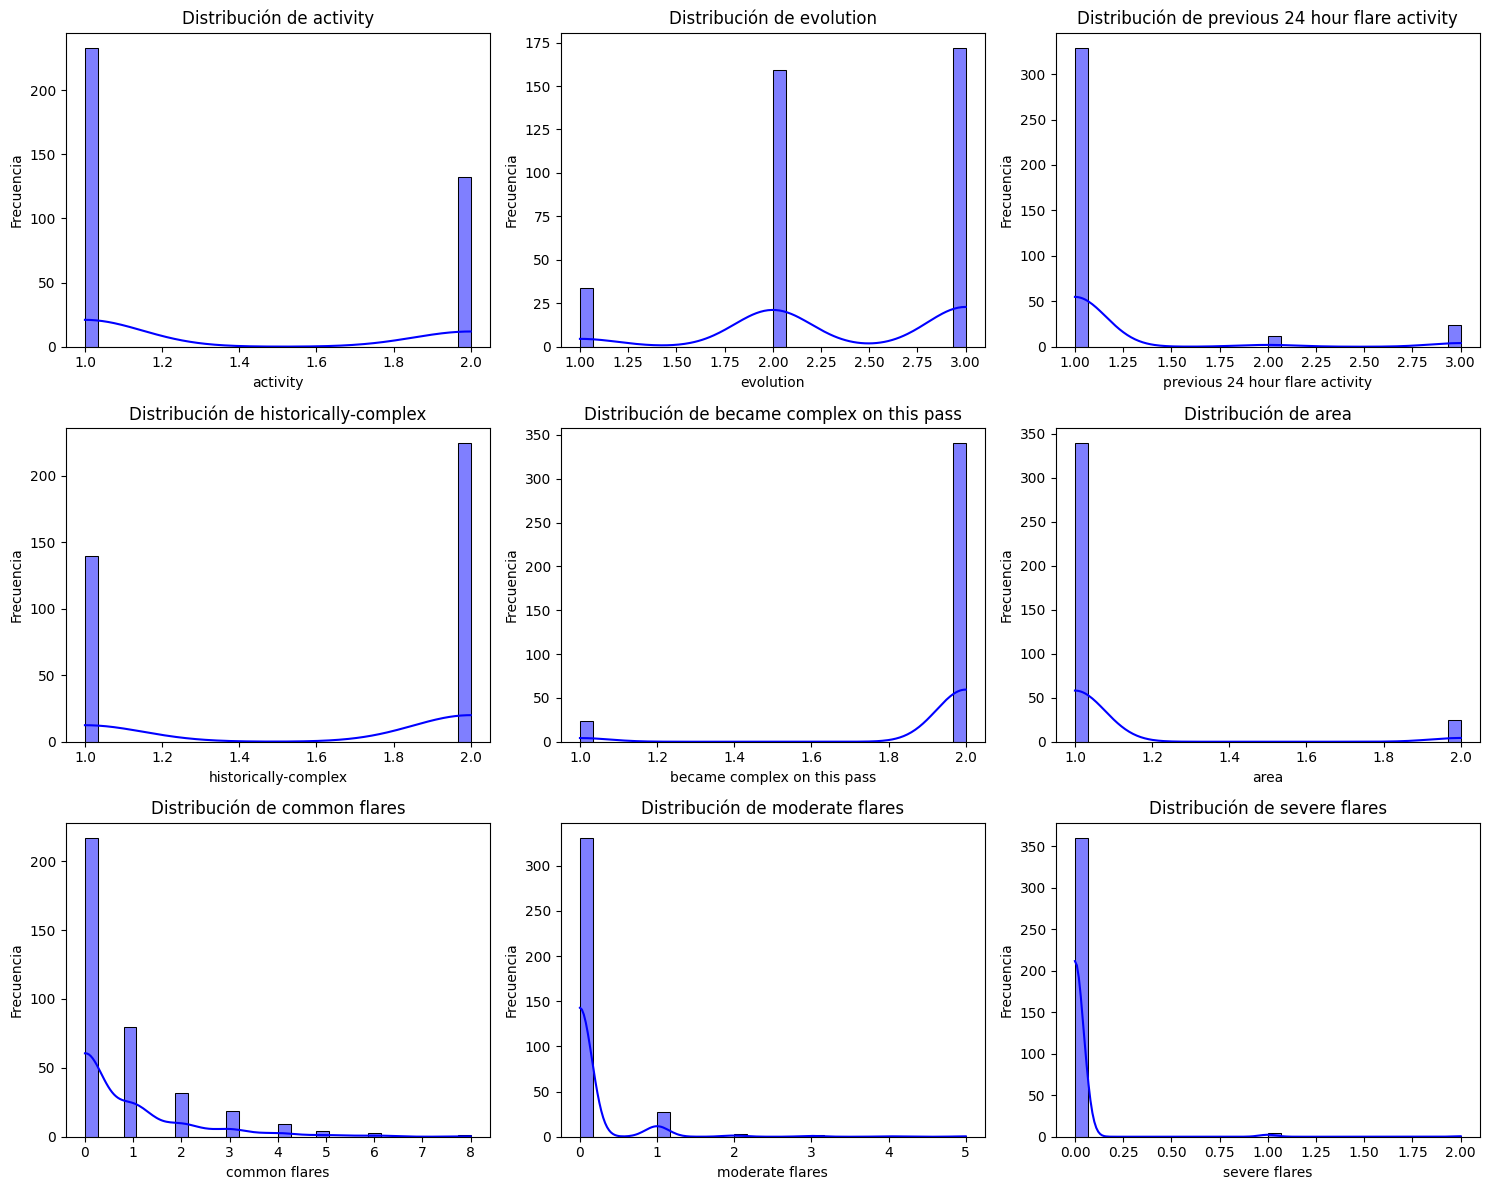


Gráficos de Barras para Variables Categóricas


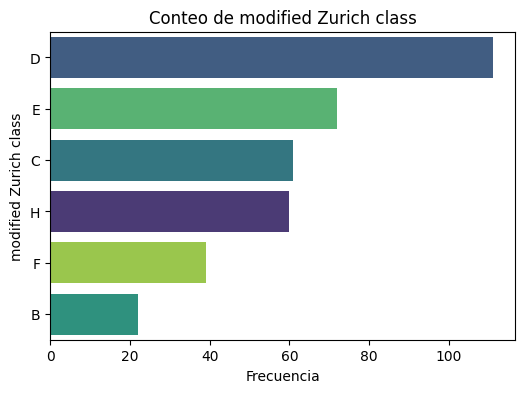

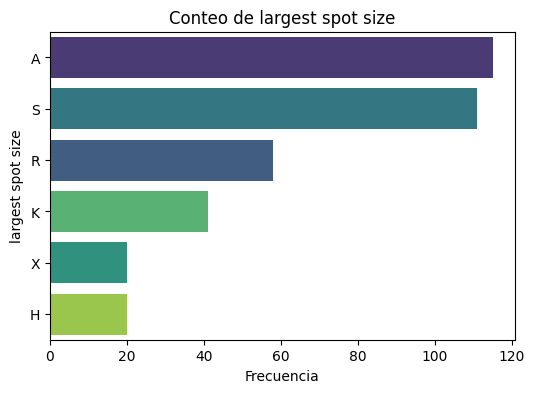

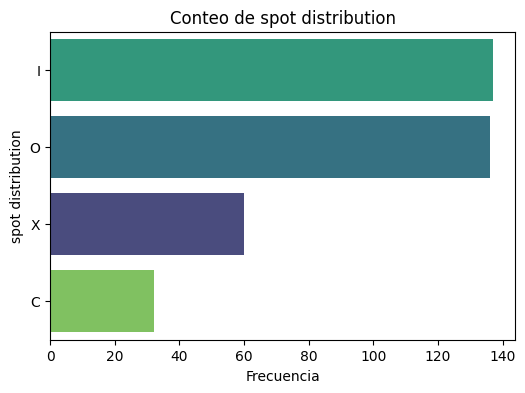

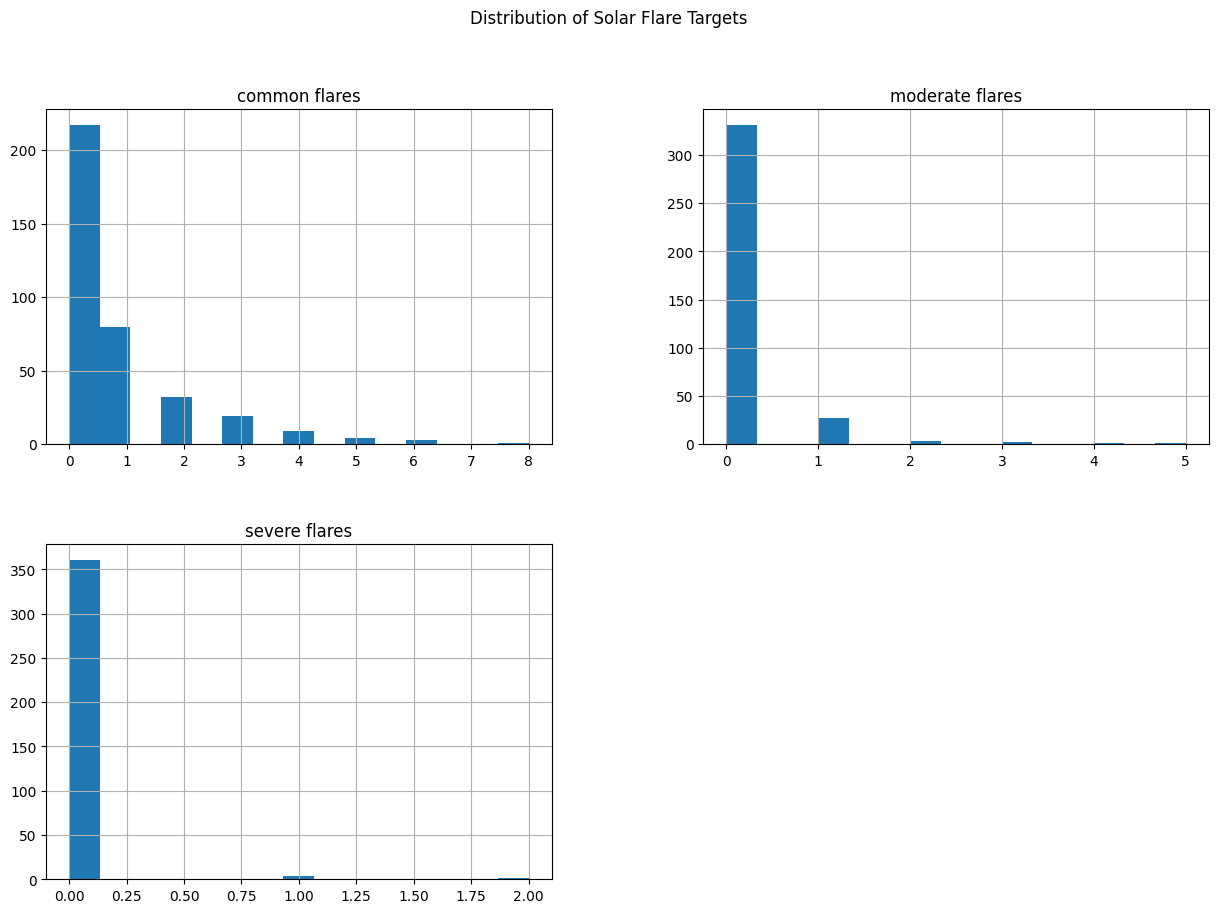

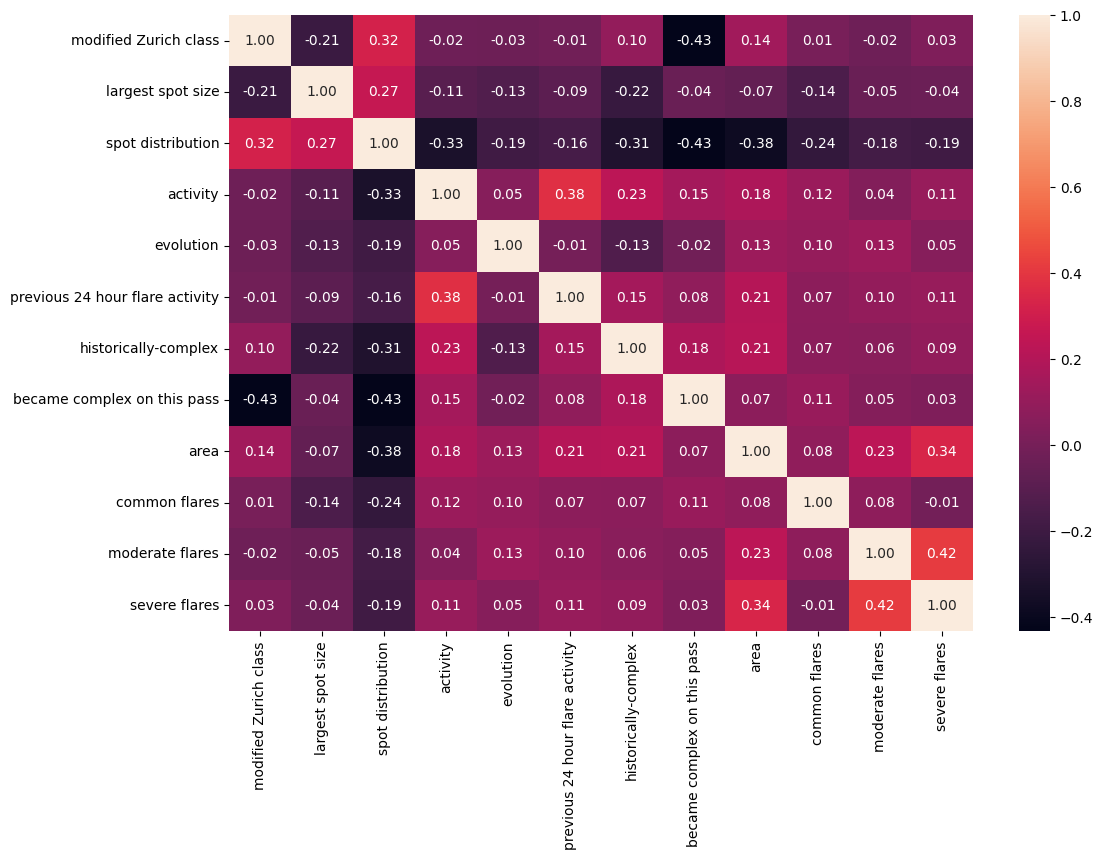

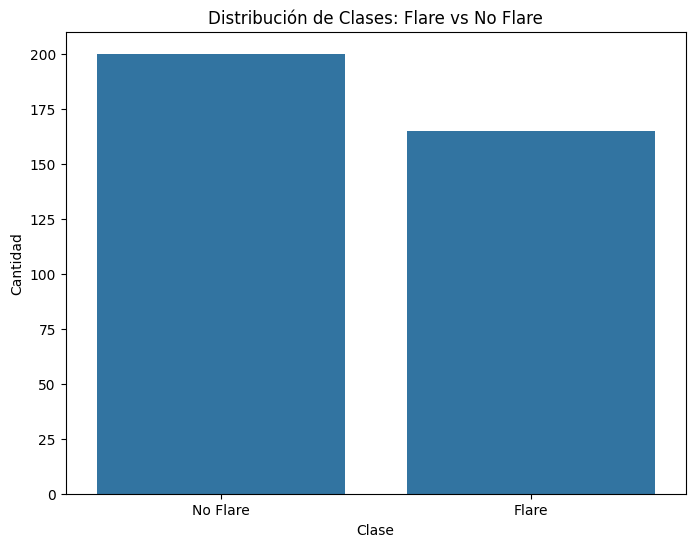

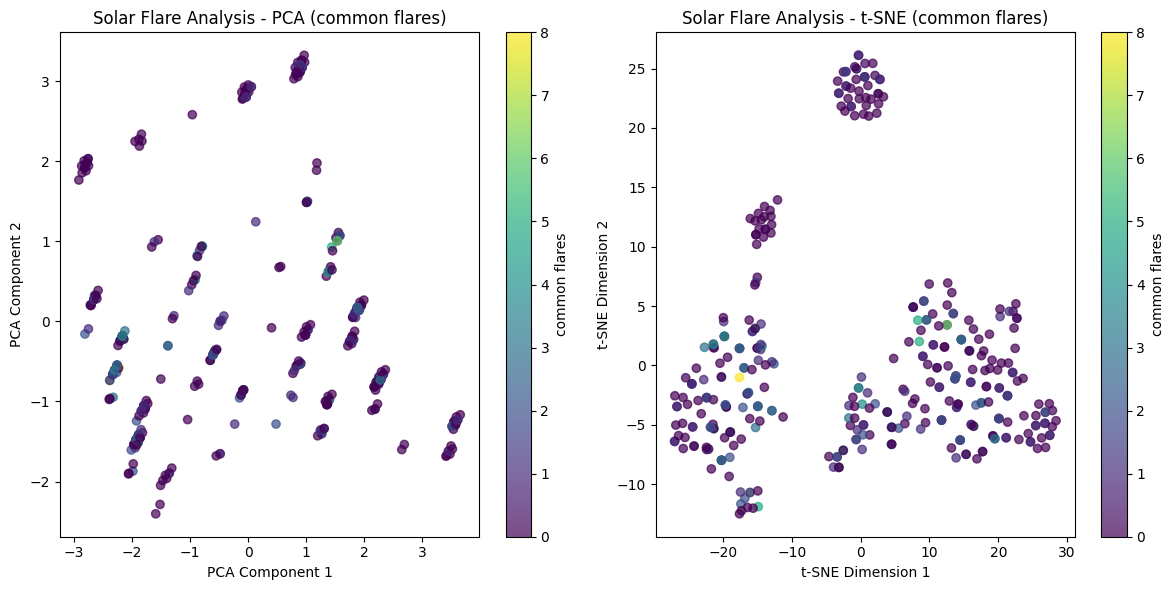

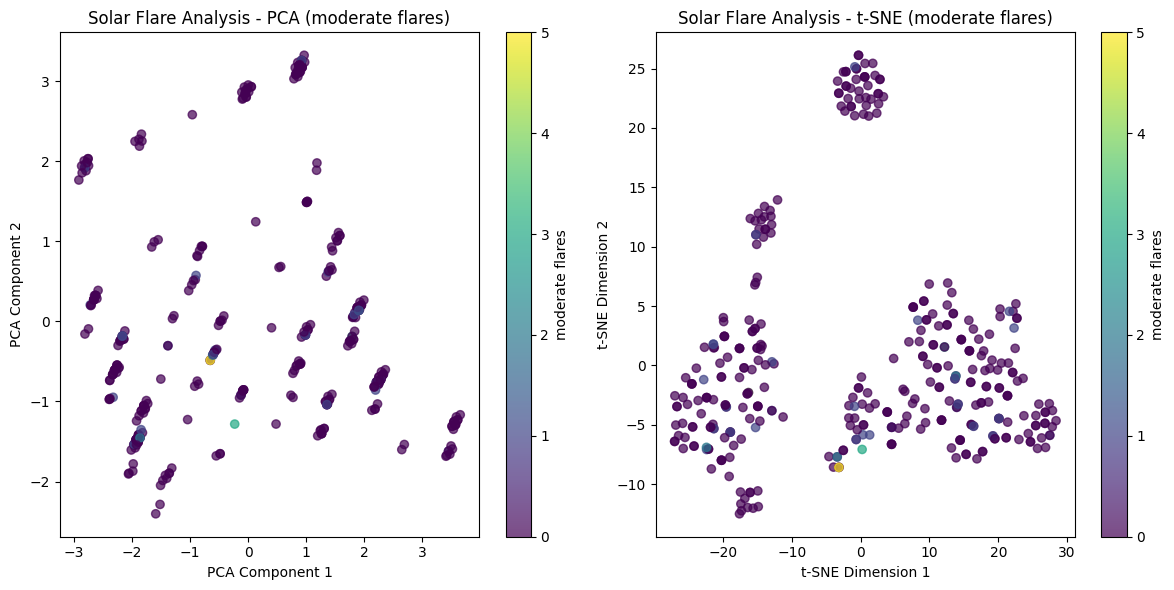

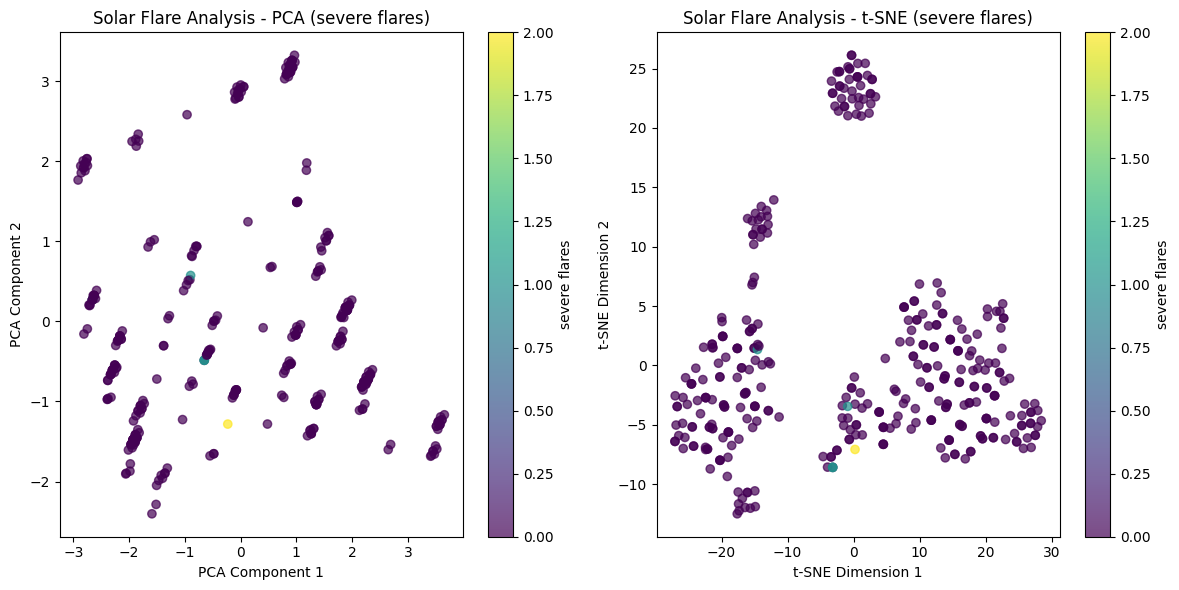

X_train shape: torch.Size([292, 9])
X_test shape: torch.Size([73, 9])
y_train shape: [torch.Size([292, 1]), torch.Size([292, 1]), torch.Size([292, 1])]
y_test shape: [torch.Size([73, 1]), torch.Size([73, 1]), torch.Size([73, 1])]
Linear Model
Epoch [1/10] - Average Loss: 0.2050
Epoch [1/10] - Average Loss: 0.4464
Epoch [1/10] - Average Loss: 0.6195
Epoch [1/10] - Average Loss: 0.9973
Epoch [1/10] - Average Loss: 1.2752
Epoch [1/10] - Average Loss: 1.5955
Epoch [1/10] - Average Loss: 1.7058
Epoch [1/10] - Average Loss: 1.8883
Epoch [1/10] - Average Loss: 1.9681
Epoch [1/10] - Average Loss: 2.0050
Epoch [2/10] - Average Loss: 0.2349
Epoch [2/10] - Average Loss: 0.3575
Epoch [2/10] - Average Loss: 0.7001
Epoch [2/10] - Average Loss: 0.7949
Epoch [2/10] - Average Loss: 1.0669
Epoch [2/10] - Average Loss: 1.2445
Epoch [2/10] - Average Loss: 1.4870
Epoch [2/10] - Average Loss: 1.6896
Epoch [2/10] - Average Loss: 1.8034
Epoch [2/10] - Average Loss: 1.8265
Epoch [3/10] - Average Loss: 0.2472
E

In [625]:
main()